In this notebook, we apply GMM-MI to a a simple bivariate Gaussian distribution, and transform the Y variable according to a `log` function. We repeat the estimate varying the number of available samples to fit, showing that GMM-MI is unbiased in the limit of large number of samples.

### Import packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.gmm import GMMWithMI as GMM
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical

### Define the true model (a simple bivariate Gaussian) and estimate its MI

In [2]:
n_components = 1
weights = np.array([1.])
means = np.zeros((1, 2))
C0 = [[1, 0.6], [0.6, 1]] # correlation is fixed to 0.6
covariances = np.array([C0])
analytic = calculate_MI_D1_analytical(covariances[0])

### Repeat the estimates on 500 independent realisations

In [3]:
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5, reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=5, n_folds=3)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100)

In [4]:
N_values = [200, 2000, 20000]
random_states = 500
transformation = 'log'

def nonlinear_transformation(x, transformation=transformation):
    if transformation == 'linear':
        x[:, 1] = x[:, 1]
    elif transformation == 'square':
        x[:, 1] = x[:, 1] + 0.1 * x[:, 1]**2 
    elif transformation == 'log':
        x[:, 1] = np.log(x[:, 1]+5.0)      
    return x

for N in N_values:
    results_file = f'./results/MI_{transformation}_{random_states}_{N}.npy'

    if os.path.isfile(results_file):
        print('Not running this cell, since results file already exists. '
              'Loading pre-computed results...')
        all_MI_estimates = np.load(results_file)
    else:
        print(f'Estimating MI, and saving results...')
        all_MI_estimates = np.zeros((random_states, 2))

        for r in range(random_states):
            # create different realisation of ground truth; note the different random_state each time
            X = GMM(n_components=n_components, weights_init=weights, 
                              means_init=means, covariances_init=covariances, 
                              random_state=r).sample(N)[0]  
            X = nonlinear_transformation(X)

            mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                      select_components_params=select_components_params,
                                      mi_dist_params=mi_dist_params)
            MI_mean, MI_std = mi_estimator.fit(X)   

            all_MI_estimates[r, 0] = MI_mean
            all_MI_estimates[r, 1] = MI_std

            np.save(results_file, all_MI_estimates)
    print(N)

Not running this cell, since results file already exists. Loading pre-computed results...
200
Not running this cell, since results file already exists. Loading pre-computed results...
2000
Not running this cell, since results file already exists. Loading pre-computed results...
20000


### Plot the results

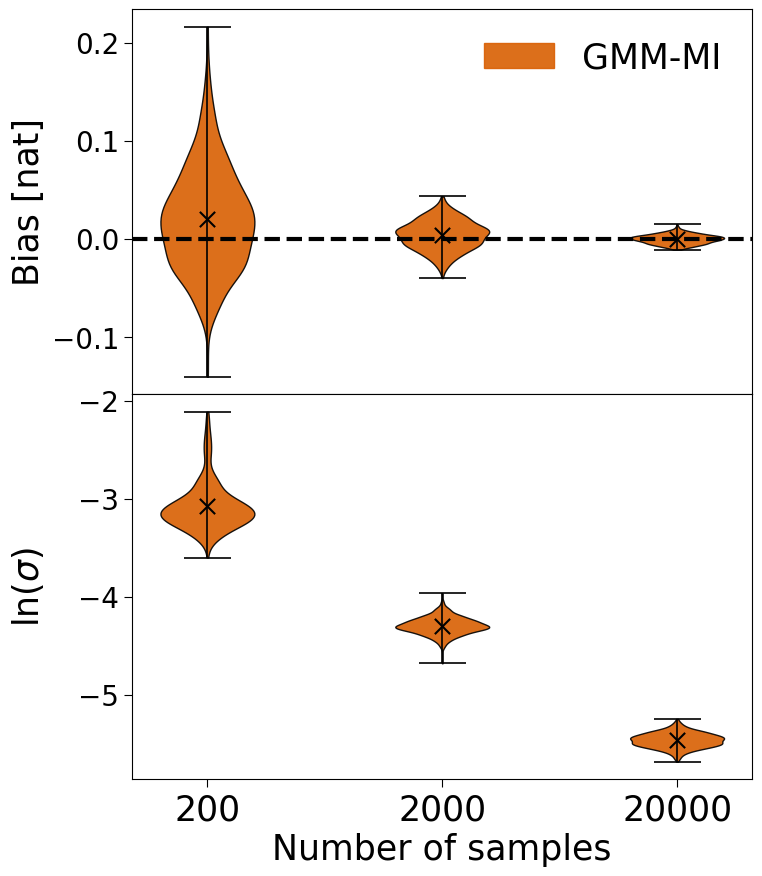

In [5]:
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))


analytic = calculate_MI_D1_analytical(covariances[0])
y_values = np.zeros((len(N_values), 500))
std_values = np.zeros((len(N_values), 500))

for i, N in enumerate(N_values):
    MI_file = np.load(f'./results/MI_{transformation}_500_{N}.npy')
    y_values[i] = MI_file[:, 0]-analytic 
    std_values[i] = np.log(MI_file[:, 1])

alpha=1
fontsize=25
color = '#d95f02'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

ax1.axhline(0, linewidth=3, c='black', linestyle='--')
parts = ax1.violinplot(y_values.T, showmeans=True, widths=0.4)
for pc in parts['bodies']:
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1.2)    
add_label(parts, 'GMM-MI')  
xy = [[l.vertices[:,0].mean(),l.vertices[0,1]] for l in parts['cmeans'].get_paths()]
xy = np.array(xy)
ax1.scatter(xy[:,0], xy[:,1], s=121, c="black", marker="x", zorder=3)
# make lines invisible
parts['cmeans'].set_visible(False) 

parts = ax2.violinplot(std_values.T, showmeans=True, widths=0.4)
for pc in parts['bodies']:
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1.2)   
xy = [[l.vertices[:,0].mean(),l.vertices[0,1]] for l in parts['cmeans'].get_paths()]
xy = np.array(xy)
ax2.scatter(xy[:,0], xy[:,1], s=121, c="black", marker="x", zorder=3)
# make lines invisible
parts['cmeans'].set_visible(False) 

ax1.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.tick_params(axis='both', which='major', labelsize=20, size=6)
ax2.set_xlabel('Number of samples', fontsize=fontsize)
ax1.set_ylabel('Bias [nat]', fontsize=fontsize)
ax2.set_ylabel('$\ln(\sigma)$', fontsize=fontsize)
fig.subplots_adjust(wspace=0, hspace=0)
ax1.legend(*zip(*labels), loc='upper right', frameon=False, fontsize=25)
ax2.set_xticks(np.arange(1, 4)) 
ax2.set_xticklabels(N_values, fontsize=fontsize)

fig.align_ylabels()
fig.savefig(f'./figures/{transformation}_transformation.pdf', bbox_inches='tight');